
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

from utils import get_data, neg_log_likelihood_one, generate_bnn_code_relu, generate_bnn_code_observe, generate_bnn_parameters, optimize, make_dataset, append_observe_block
import vi_model
from parallel_loss import run_parallel

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from pyro.distributions import constraints
import pyro.distributions as dist

torch.set_default_dtype(torch.float32)
import time
import json

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']
['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']
['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages'

### Training the BNN with VI in Pyro

X.shape torch.Size([500, 1, 1]) Y.shape torch.Size([500, 1, 1])


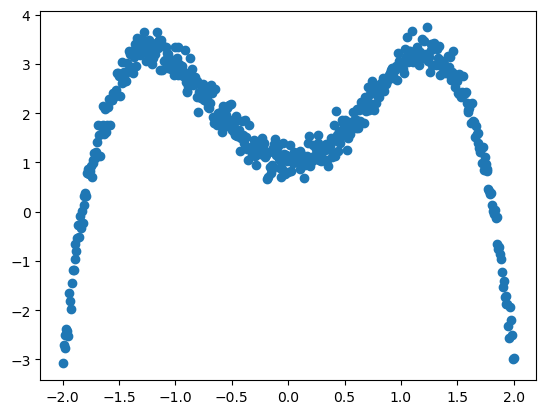

In [3]:
args = [100, 2, 4]
N = 500
N_test = 50 
D_X = 2 
D_H = 4
n_hidden = 2
n_neurons = 3
#X, Y, X_test = get_data(N=N, D_X=D_X)

X, Y, X_test, Y_test = make_dataset(func_id=5, N=N, N_test=N_test, sigma=0.2)

X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

print('X.shape', X.shape, 'Y.shape', Y.shape)
plt.scatter(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy())

Step 0 - Loss: 115641.7500
Step 2000 - Loss: 45330.4894
Step 4000 - Loss: 46503.5523
Step 6000 - Loss: 46081.9916
Step 8000 - Loss: 46055.7124
Step 10000 - Loss: 16626.9048
Step 12000 - Loss: 13502.3913
Step 14000 - Loss: 13400.8391
Step 16000 - Loss: 13311.0259
Step 18000 - Loss: 13304.9713
Training complete!


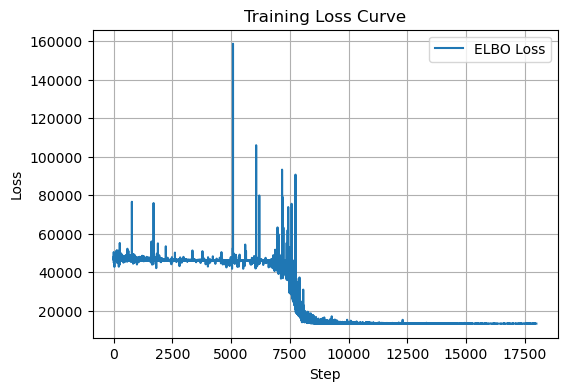

Training time: 82.82348203659058


In [3]:
# Variational Inference
torch.set_default_dtype(torch.float32)

start = time.time()
losses = vi_model.train_vi(vi_model.model, vi_model.guide, X, Y, n_hidden, n_neurons, num_steps = 20000, lr = 0.01)
end = time.time()
print("Training time:", end - start)

In [4]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.detach().numpy()}")

w1_loc: [[ 1.783502  -1.7870711  0.0660069]]
w1_scale: [[0.00119601 0.00122691 0.18841721]]
b1_loc: [-2.656271  -2.6786137 -1.7741919]
b1_scale: [0.0021152  0.00205163 0.21919651]
w2_loc: [[-0.1996767  -0.1468937   3.1869156 ]
 [-0.21631244 -0.3345669   3.2077317 ]
 [-0.01750795 -0.05773438  0.12680696]]
w2_scale: [[0.6796469  0.7319232  0.010779  ]
 [0.5884436  0.65673226 0.01207771]
 [1.0409166  0.9980408  0.5007302 ]]
b2_loc: [-1.3168051 -1.170983  -0.8102692]
b2_scale: [0.31964946 0.35118026 0.00428254]
w_out_loc: [[-0.15003695]
 [-0.29969364]
 [-2.33762   ]]
w_out_scale: [[0.33078328]
 [0.805647  ]
 [0.00876319]]
b_out_loc: [2.262334]
b_out_scale: [0.00418917]


In [5]:
Y_train = vi_model.predict_vi(X, pyro.param, n_hidden, n_neurons)

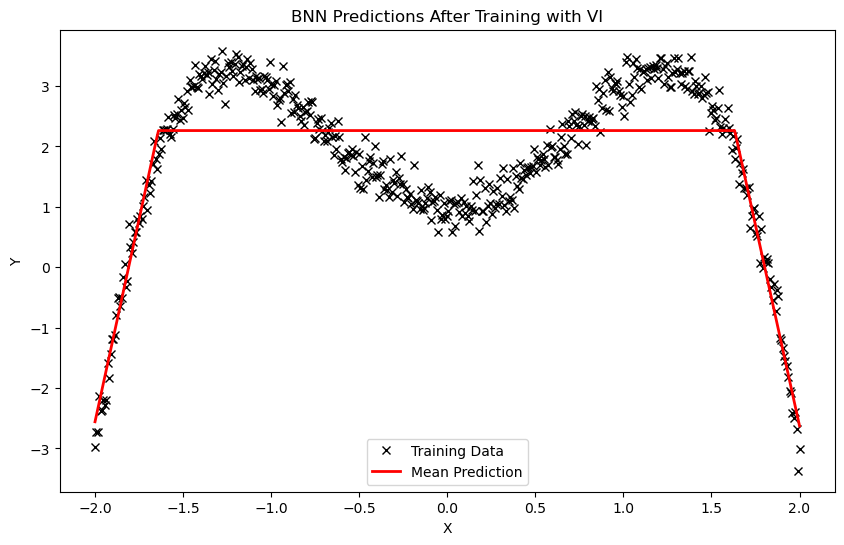

In [6]:


# Visualize the results of the BNN trained using Variational Inference
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx", label="Training Data")

# Predictive mean after training

# Plot mean prediction
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="Mean Prediction")

# Add labels, legend, and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("BNN Predictions After Training with VI")
plt.legend()

# Show the plot
plt.show()

In [7]:
#compute r^2 on the test set
Y_test_pred = vi_model.predict_vi(X_test, pyro.param, n_hidden, n_neurons)
ss_res = torch.sum((Y_test - Y_test_pred)**2)
ss_tot = torch.sum((Y_test - torch.mean(Y_test))**2)
r2 = 1 - ss_res/ss_tot
print(f"R^2 on test set: {r2.item():.4f}")

R^2 on test set: 0.7582


### Sanity check on SOGA program

We use the parameters found by VI in SOGA to check that the BNN is correctly encoded

In [8]:
def extract_vi_parameters(n_hidden, n_neurons, param_store):
    """
    Extract Pyro variational parameters and map them into a dictionary
    consistent with the DSL code generated by `generate_bnn_code`.

    Supports two naming conventions for the output layer:
      - "w{n_hidden+1}_loc", "b{n_hidden+1}_loc"
      - "w_out_loc", "b_out_loc"
    """

    vi_pars = {}
    w_counter = 1
    b_counter = 1

    # --- Hidden layers ---
    in_dim = 1
    for layer in range(n_hidden):
        W_mean = param_store[f"w{layer+1}_loc"].detach().numpy()
        W_std  = param_store[f"w{layer+1}_scale"].detach().numpy()
        b_mean = param_store[f"b{layer+1}_loc"].detach().numpy()
        b_std  = param_store[f"b{layer+1}_scale"].detach().numpy()

        for i in range(in_dim):        # inputs
            for j in range(n_neurons): # neurons
                vi_pars[f"muw{w_counter}"]    = torch.tensor(W_mean[i, j], requires_grad=True)
                vi_pars[f"sigmaw{w_counter}"] = torch.tensor(W_std[i, j], requires_grad=True)
                w_counter += 1

        for j in range(n_neurons):     # biases
            vi_pars[f"mub{b_counter}"]    = torch.tensor(b_mean[j], requires_grad=True)
            vi_pars[f"sigmab{b_counter}"] = torch.tensor(b_std[j], requires_grad=True)
            b_counter += 1

        in_dim = n_neurons

    # --- Output layer ---
    # check which naming scheme is used
    if f"w{n_hidden+1}_loc" in param_store:
        W_mean = param_store[f"w{n_hidden+1}_loc"].detach().numpy()
        W_std  = param_store[f"w{n_hidden+1}_scale"].detach().numpy()
        b_mean = param_store[f"b{n_hidden+1}_loc"].detach().numpy()
        b_std  = param_store[f"b{n_hidden+1}_scale"].detach().numpy()
    else:  # use "w_out", "b_out"
        W_mean = param_store["w_out_loc"].detach().numpy()
        W_std  = param_store["w_out_scale"].detach().numpy()
        b_mean = param_store["b_out_loc"].detach().numpy()
        b_std  = param_store["b_out_scale"].detach().numpy()

    for i in range(in_dim):
        vi_pars[f"muw{w_counter}"]    = torch.tensor(W_mean[i, 0], requires_grad=True)
        vi_pars[f"sigmaw{w_counter}"] = torch.tensor(W_std[i, 0], requires_grad=True)
        w_counter += 1

    vi_pars[f"mub{b_counter}"]    = torch.tensor(b_mean[0], requires_grad=True)
    vi_pars[f"sigmab{b_counter}"] = torch.tensor(b_std[0], requires_grad=True)
    b_counter += 1

    return vi_pars


In [9]:
from pyro import get_param_store

param_store = get_param_store()
vi_pars = extract_vi_parameters(n_hidden, n_neurons, param_store)
print(vi_pars)

{'muw1': tensor(1.7835, requires_grad=True), 'sigmaw1': tensor(0.0012, requires_grad=True), 'muw2': tensor(-1.7871, requires_grad=True), 'sigmaw2': tensor(0.0012, requires_grad=True), 'muw3': tensor(0.0660, requires_grad=True), 'sigmaw3': tensor(0.1884, requires_grad=True), 'mub1': tensor(-2.6563, requires_grad=True), 'sigmab1': tensor(0.0021, requires_grad=True), 'mub2': tensor(-2.6786, requires_grad=True), 'sigmab2': tensor(0.0021, requires_grad=True), 'mub3': tensor(-1.7742, requires_grad=True), 'sigmab3': tensor(0.2192, requires_grad=True), 'muw4': tensor(-0.1997, requires_grad=True), 'sigmaw4': tensor(0.6796, requires_grad=True), 'muw5': tensor(-0.1469, requires_grad=True), 'sigmaw5': tensor(0.7319, requires_grad=True), 'muw6': tensor(3.1869, requires_grad=True), 'sigmaw6': tensor(0.0108, requires_grad=True), 'muw7': tensor(-0.2163, requires_grad=True), 'sigmaw7': tensor(0.5884, requires_grad=True), 'muw8': tensor(-0.3346, requires_grad=True), 'sigmaw8': tensor(0.6567, requires_gr

In [10]:
torch.set_default_dtype(torch.float64)

# This is the X vector used in the script
X_soga = torch.tensor(X.squeeze(-1).squeeze(-1).numpy(), dtype=torch.float64)

soga_code = generate_bnn_code(n=n_hidden, m=n_neurons)  # two hidden layers, 3 neurons each


compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)


y_means = []
loss = 0.
for j in range(len(X.squeeze(-1).squeeze(-1))):
    xj = X.squeeze([-1,1])[j]
    vi_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, vi_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())
    loss += neg_log_likelihood_one(torch.tensor(Y.squeeze(-1)[j], dtype=torch.float64 ), current_dist)   

#output_dist = start_SOGA(cfg, vi_pars, pruning='ranking') #params_dict 


plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
#plt.plot(X.numpy().flatten(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="variational inference")
plt.plot(X_soga.numpy().flatten(), y_means, "green", ls="solid", lw=2.0, label='SOGA')

plt.legend()

print("Loss SOGA:", loss.item())


NameError: name 'generate_bnn_code' is not defined

### Optimization in SOGA

We use a different script in which the std of the weights are fixed (if not the loss is better for higher stds).
Moreover we add noise to the output to avoid infinite loss

In [4]:
bnn_one_pars = generate_bnn_parameters(n=n_hidden, m=n_neurons)

In [ ]:
torch.set_default_dtype(torch.float64)

soga_code = generate_bnn_code_relu(n=n_hidden, m=n_neurons)
#soga_code = generate_bnn_code_observe(n=n_hidden, m=n_neurons)
#soga_code = append_observe_block(soga_code, "x > 8", "y > 0")
constraint_str = """
x = _x;
if x > -0.3 {
    if x < 0.3 {
        observe(y > 2.5);
        observe(y < 3.);
    } else {
        skip;
    } end if;
} else {
    skip;
} end if;"""

soga_code = soga_code + "\n" + constraint_str
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#bnn_one_pars = {'muw1':1., 'muw2': -1., 'muw3': 1., 'muw4': -1., 'muw5': -1., 'muw6': 1., 'muw7': -1., 'muw8': -1.,  
            #'mub1': -1., 'mub2': -1., 'mub3': -1., 'mub4': 1., 'mub5': 1.,
            #'sigmaw1': 0.1, 'sigmaw2': 0.1, 'sigmaw3': 0.1, 'sigmaw4': 0.1, 'sigmaw5': 0.1, 'sigmaw6': 0.1, 'sigmaw7': 0.1, 'sigmaw8': 0.1,
            #'sigmab1': 0.1, 'sigmab2': 0.1, 'sigmab3': 0.1, 'sigmab4': 0.1, 'sigmab5': 0.1,}

#remove from X the points where x is between -0.3 and 0.3
mask = (X.squeeze(-1).squeeze(-1) < -0.3) | (X.squeeze(-1).squeeze(-1) > 0.3)
X = X[mask]
Y = Y[mask]
print('X.shape', X.shape, 'Y.shape', Y.shape)   
#plt.scatter(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy())

bnn_one_pars = optimize(bnn_one_pars, cfg, X, Y, steps = 500, lr = 0.001)


X.shape torch.Size([426, 1, 1]) Y.shape torch.Size([426, 1, 1])
 loss: 29.619502645239326muw1: -0.19249984839293127 sigmaw1: 0.6520562227774714 mub1: 0.40881768861730094 sigmab1: 0.001286603816069423 muw2: -0.9106469133001122 sigmaw2: 0.07844729593688761 mub2: 0.020300239714006685 sigmab2: 1e-06 muw3: 0.2100414259983071 sigmaw3: 0.16098590376062433 mub3: 1.3484725841551468 sigmab3: 0.0010008141357994535 muw4: 0.7460646816528775 sigmaw4: 0.1 muw5: 0.4813092199307989 sigmaw5: 0.1 muw6: 0.11203506763123117 sigmaw6: 0.1 mub4: -0.014323779554963594 sigmab4: 0.001000842194013789 muw7: -0.3803003752139047 sigmaw7: 0.1 muw8: -0.563552566007677 sigmaw8: 0.1 muw9: -0.04025743468974641 sigmaw9: 0.1 mub5: 0.6209670682554337 sigmab5: 0.0010008727550676428 muw10: -0.7024854373300103 sigmaw10: 0.0009966487857502727 muw11: 0.7529764586010435 sigmaw11: 1e-06 muw12: 1.2019249515437986 sigmaw12: 0.001000947949133835 mub6: 0.9030879938847719 sigmab6: 0.0009992556771280792 muw13: 1.2972437242027752 sigmaw1

In [ ]:
#import json

#save on file and load bnn_one_pars
with open('bnn_one_pars.json', 'w') as f:
    json.dump({key: value.item() for key, value in bnn_one_pars.items()}, f)

with open('bnn_one_pars.json', 'r') as f:
    bnn_one_pars = json.load(f)

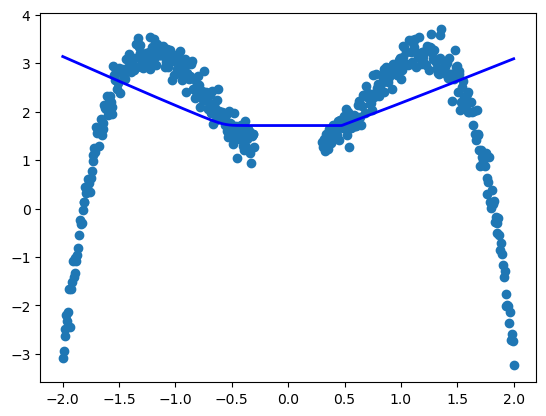

In [4]:
y_means = []
for j in range(len(Y.squeeze([-1,1]))):
    yj = Y.squeeze([1])[j].to(torch.float64)
    xj = X.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())

# plot training data
plt.scatter(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy())
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), y_means, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
plt.show()

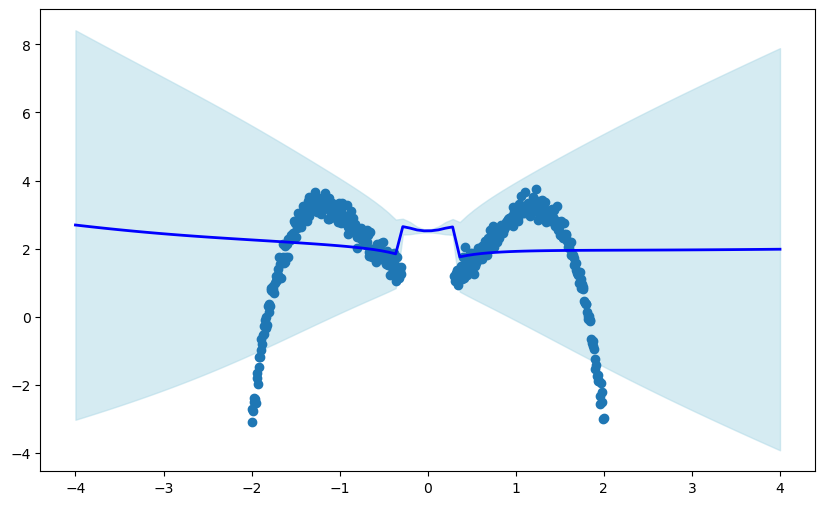

In [ ]:
#generate a set of X_larger between -4 and 4 and predict the corresponding Y_larger
X_larger = torch.linspace(-4, 4, 100).unsqueeze(-1)

Y_larger = []
Y_larger_var = []
for j in range(len(X_larger)):
    xj = X_larger[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    Y_larger.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())
    Y_larger_var.append(torch.sqrt(current_dist.gm.cov()[current_dist.var_list.index('y'), current_dist.var_list.index('y')]).detach().numpy())

#plot X_larger vs Y_larger with a confidence interval of 2 standard deviations
plt.figure(figsize=(10, 6))
plt.plot(X_larger.numpy().flatten(), Y_larger, "blue", ls="solid", lw=2.0, label='SOGA prediction')
plt.fill_between(X_larger.numpy().flatten(), 
                 (np.array(Y_larger) - 2*np.array(Y_larger_var)).flatten(), 
                 (np.array(Y_larger) + 2*np.array(Y_larger_var)).flatten(), 
                 color="lightblue", alpha=0.5, label='Confidence Interval (2 std)')
plt.scatter(X.numpy().flatten(), Y.numpy().flatten(), label="Training Data")
         

In [ ]:
#save in csv X_larger, Y_larger, Y_larger_var
import pandas as pd
df = pd.DataFrame({'X': X_larger.numpy().flatten(), 'Y_mean': Y_larger, 'Y_std': Y_larger_var})
df.to_csv('bnn_1_Cost1.csv', index=False)

In [ ]:

Y_test_pred = []

X_test = X_test.unsqueeze(-1)
Y_test = Y_test.unsqueeze(-1)
for j in range(len(Y_test.squeeze([-1,1]))):
    yj = Y_test.squeeze([1])[j].to(torch.float64)
    xj = X_test.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    Y_test_pred.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach())

ss_res = torch.sum((Y_test.squeeze() - torch.tensor(Y_test_pred))**2)
ss_tot = torch.sum((Y_test.squeeze() - torch.mean(Y_test.squeeze()))**2)
r2 = 1 - ss_res/ss_tot
print(f"R^2 on test set: {r2.item():.4f}")

R^2 on test set: 0.8650
